#1. Randomized Search e Cross validation combinadas

O que será visto:

- O que é um random search

- Diferença entre random search e grid search

##Introdução



No curso anterior sobre otimização de estimadores por meio de hiperparâmetros, estávamos, em um grid, discretizando o espaço de hiperparâmetros e buscando, de maneira exaustiva, os melhores resultados.

Por exemplo: quando nosso estimador tinha duas dimensões (max_depth e min_samples_leaf), nós testávamos diversos valores diferentes em sequência, abordando todo aquele espaço de parâmetros no grid.

Feito isso, decidíamos explorar de maneira mais refinada determinados espaços... e assim sucessivamente. Porém, esse processo consome muito tempo e processamento computacional, o que certamente resultaria em custos financeiros.

Se tínhamos esse problema com duas dimnesões, imagine se tivésses três dimensões, ou quatro... ou uma quantidade ainda maior de parâmetros?O número de combinações gerado seria gigantesco, e levaria muito tempo para chegarmos a um resultado.

Existem outras maneiras de buscarmos a melhor otimização para nossos estimadores. Por exemplo, ao invés de explorarmos exaustivamente o espaço de parâmetros (ou um subespaço discretizado), colocaremos nossos hiperparâmetros em um grid (não necessariamente de maneira discreta, mas também de maneira contínua), e testaremos valores aleatórios.

A ideia é que não existe a necessidade de explorar todo o espaço de parâmetros para encontrar pontos de mínimo ou de máximo que sejam bons o suficiente para o problema que estivermos tentando resolver - não necessariamente o mínimo global ou o máximo global, mas valores que sejam suficientemente adequados para a situação problema.

O Random search se comporta como abaixo:

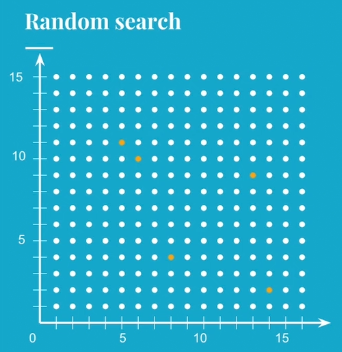

Ou seja, enquanto a busca no grid (grid search) vai varrer todas as possibilidades e demora muito tempo, apesar de ser possível rodá-lo de maneira paralela, a busca aleatória (random search) vai rodar em menos tempo e permite outras otimizações, pois não iremos explorar exaustivamente todos os valores possíveis do nosso espaço de hiperparâmetros. 

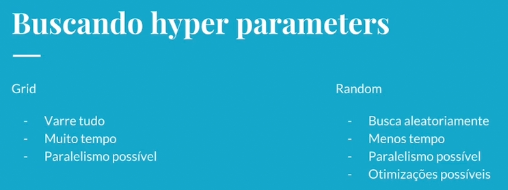

Nesse curso, aprenderemos como implementar uma busca aleatória e como preparar as soluções a partir disso. Assim como no curso anterior, na maior parte do processo trabalharemos com a validação cruzada.

Porém, em determinado ponto, também abordaremos, com o auxílio do train_test_split, a otimização de hiperparâmetros sem validação cruzada, mantendo as fases de treino, teste e validação.

Dessa forma, você terá as duas opções para utilizar no seu dia-a-dia. Vamos começar!


##Explorando aleatoriamente

Já aprendemos que, quando temos um espaço de parâmetros com duas dimensões, podemos explorá-lo ponto a ponto. Isto é, transformamos espaços contínuos em espaços discretos e exploramos, nesses pontos, o nosso algorítimo.

Por exemplo, se estamos trabalhando com um algorítimo de DecisionTreeClassifier que tem os parâmetros max_depth e min_samples_leaf, podemos testar cada um desses parâmetros com um valor específico. Depois de medirmos o resultado, repetimos o processo para o próximo parâmetro.

Dessa forma, exploramos o espaço até completarmos o grid todo. Por exemplo, se temos 15 condições para cada parâmetro, rodamos o algorítimo 225 vezes para explorar esse espaço por completo.

Mas e quando temos 3 parâmetros, cada um com uma determinada quantidade de condições? Nesse caso, ainda poderíamos plotar esses dados em um gráfico 3D... mas e se tivéssemos 4 parâmetros ou mais?

Supondo que tivéssemos 3 parâmetros com 64 condições cada um, e um parâmetro com apenas 2 condições. Nessa situação, teríamos que explorar 524.288 possibilidades de parâmetros. Se cada uma dessas explorações levasse 5 minutos (o que é um exemplo razoável), seriam necessários 1820 dias para testar todas essas possibilidades. Se estivéssemos rodando esse algorítimo em 5 máquinas, ainda assim levaríamos 1 ano para terminar o processo.

Vamos analisar o grid de duas dimensões abaixo:

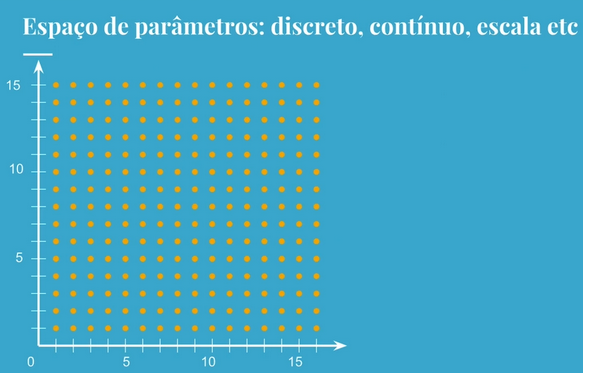

*grid com dois eixos de 15 pontos cada, gerando 225 elementos*

Mesmo que não haja garantia disso, esperamos que os valores representados no grid tenham resultados próximos aos seus vizinhos. Ou seja, pode não existir uma mudança brusca entre pontos muito próximos do nosso espaço discretizado de parâmetros.

Com isso em mente, ao invés de tentarmos explorar todo o grid (o que é feito no grid search), poderíamos buscar pontos aleatoriamente (random search). E é exatamente isso que faremos agora.

Começaremos essa busca aleatória ao final do projeto no qual trabalhamos no curso anterior.

Para organizarmos nosso trabalho, adicionaremos uma célula de texto indicando onde se inicia o RandomSearch. Esse processo de busca é bastante parecido com tudo o que fizemos anteriormente, e também se inicia definindo um espaço de parâmetros a ser explorado.

**Busca aleatória: RandomSearch**

Para começarmos, vamos trazer os dados novamente para cá, até o ponto necessário para iniciarmos ocm o RandomSearch:

In [1]:
# Carga dos dados
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [2]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão
# Feito propositalmente para simular uma situação em que a simples técnica de hold out (treino/teste) levaria a resultados ruins.
# E aí isso instigou a necessidade de usarmos validação cruzada.

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


Portanto, começaremos copiando o código que criamos para GridSearchCV:

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012141,0.002045,0.002632,0.000460,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.010183,0.000349,0.002486,0.000768,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.010095,0.000168,0.002286,0.000330,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.010055,0.000147,0.002126,0.000115,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.013078,0.002243,0.003118,0.000582,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


Em seguida, alteraremos os campos em que GridSearchCV aparece para RandomizedSearchCV. Manteremos a mesma SEED e o mesmo espaço de parâmetros (com 36 possibilidades). Quando trabalhos com processos aleatórios, é muito comum que o modelo contenha um parâmetro random_state para manter a consistência entre todas as execuções. No caso, esse parâmetro receberá nosso SEED como valor.

Dentre essas 36 possibilidades de combinações de parâmetros, quantas queremos rodar? Se executarmos todas, estaremos fazendo exatamente a mesma busca que com o GridSearchCV, alterando apenas a ordem. Ou seja, devemos executar somente algumas.

Um dos parâmetros que RandomizedSearchCV pode receber é o número de iterações - **n_iter**. A ideia é, nesse momento, rodarmos apenas 16 dessas possibilidades:

In [4]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
import numpy as np

SEED=301
np.random.seed(SEED)

#Espaço de parâmetros está bem discretizado (Pelo GridSearchCV, teríamos 36 rodadas: 2x3x3x2)
espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

#Ajustando para RandomizedSearchCV
busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    n_iter = 16, #esse é o nº de iterações que ele fará. Em vez das 36 combinações, quero 16 aleatórias.
                    cv = KFold(n_splits = 5, shuffle=True),
                    random_state = SEED) #para manter consistência nas execuções

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.020178,0.002218,0.003242,0.000101,128,128,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.784,0.769,0.7985,0.793,0.7730,0.7835,0.011278,13
1,0.014637,0.000479,0.003441,0.000276,64,32,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.776,0.8025,0.793,0.7795,0.7870,0.009618,1
2,0.015072,0.001703,0.003216,0.000094,64,128,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.776,0.8025,0.793,0.7795,0.7870,0.009618,1
3,0.028607,0.000434,0.003407,0.000135,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.784,0.769,0.8005,0.793,0.7730,0.7839,0.011825,7
4,0.028696,0.000174,0.003394,0.000378,64,64,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.769,0.8005,0.793,0.7730,0.7839,0.011825,7


Após a execução desse código, queremos saber quão bem se saiu o melhor classificador. Da mesma forma que no GridSearchCV, encontraremos uma resposta com cross_val_score() (nested cross validation).

A ideia é: Treinamos com um cross validation, e validamos com um outro cross validation.

O resultado na tela será um array de cinco valores:

In [5]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
scores

array([0.7825, 0.783 , 0.794 , 0.781 , 0.795 ])

Também iremos imprimir a acurácia média dessas cinco amostras e o intervalo que obtivemos.

Trazendo a função desenvolvida no curso anterior:

In [6]:
#Função com a média e o intervalo dos scores.
#Na media, usaremos scores.mean() * 100, e no desvio scores.std() * 100.

def imprime_score(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

Scores obtidos no nested cross validation:

In [7]:
imprime_score(scores)

Accuracy médio 78.71
Intervalo [77.49, 79.93]


Em seguida, vamos escolher melhor estimador.

Para encontrarmos o melhor estimador, atribuiremos a função *busca.best_estimator_* à uma variável melhor e imprimiremos essa variável na tela.

In [8]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=64)


CONCLUSÃO:

Isso significa que o melhor estimador teve o critério gini, a profundidade máxima 3, o mínimo de elementos na folha 32 e 64 como o mínimo de splits antes de tomar uma decisão. Tivemos uma acurácia média de 78.71, em um intervalo entre 77.49% e 79.93%.

Repare que executando menos da metade das buscas, obtivemos uma acurácia média e um intervalo muito parecidos com aqueles do GridSearchCV (que tinha a média 78.67% e o intervalo 76.80% a 80.54).

Nesse ponto, também podemos gerar a árvore de decisões:

In [9]:
#Será preciso instalar o graphviz, na versão 0.9 e o pydot
!pip install graphviz==0.9
!pip install pydot

#O graphviz precisa instalar com apt-get
!apt-get install graphvizv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package graphvizv


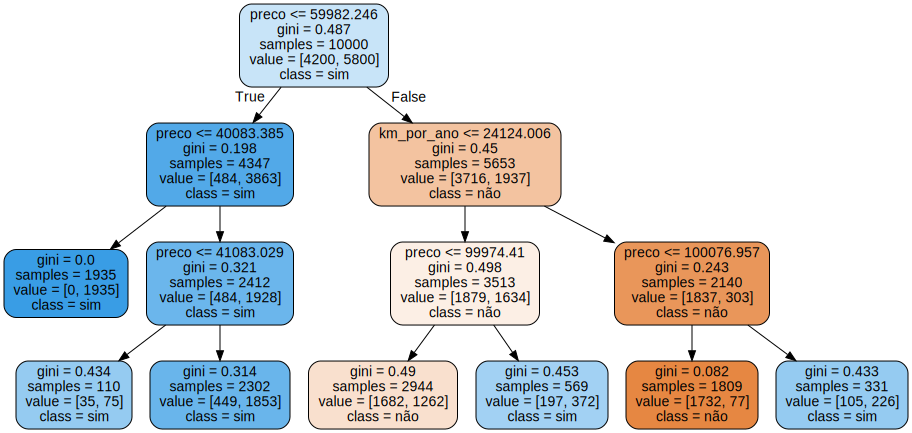

In [10]:
from sklearn.tree import export_graphviz
import graphviz


features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                        class_names=["não", "sim"],
                        feature_names = features)

graph = graphviz.Source(dot_data)
graph

Na prática, a utilização do **RandomizedSearchCV** nos permite encontrar valores muito próximos aos que mais otimizarão nossos estimadores, sem que seja necessário explorar todo o espaço de parâmetros (o que muitas vezes é impossível).

#2. Explorando por mais tempo espaços maiores

O que será visto:

- Fazer um espaçamento de parâmetros que contém números aleatórios entre 32 a 128

- Utilizar o randint do scipy.stats

- Explorar espaços

##Espaços maiores e sampling menores

Nós exploramos aleatoriamente o nosso espaço de parâmetros, mas fizemos isso de maneira bem restrita. Anteriormente, devido às limitações de processamento do GridSearchCV (principalmente em relação ao tempo), nós utilizamos somente 36 combinações.

Porém, seria mais interessante explorarmos ainda mais parâmetros no nosso algorítimo - por exemplo, um max_depth que recebesse 10, 20, 30 ou até que não tivesse limites (o que é possível com *None*, segundo a [documentação do próprio GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)).

A ideia é executarmos novamente o **RandomizedSearchCV**, mas com diferentes customizações nesse espaço de parâmetros. Por exemplo, em max_depth, ao invés de termos somente os valores 3 e 5, teremos um conjunto discreto de números inteiros (3, 5, 10, 15, 20, 30) com a adição do valor *None*.

Em *min_samples_split* e *min_samples_leaf*, queremos qualquer número inteiro aleatório entre 32 e 128. Para isso, precisaremos de uma função de aleatoriedade que devolva um número aleatório a cada execução - neste caso, *randint* (random integer). Essa função deve ser importada do pacote scipy,stats.

Segundo a [documentação do SciPy randint](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.randint.html), ele percorre desde o número mais baixo (low, no nosso código 32) até o número anterior ao mais alto (high - 1, ou seja, 127).

Isso significa que agora temos muito mais possibilidades de combinações: são 7 elementos para *max_depth*, 96 para *min_samples_split* e *min_samples_leaf*, e 2 para *criterion* - no total, 129.024 combinações diferentes de parâmetros.

Desse número, executaremos apenas 16, a mesma quantidade que estávamos executando anteriormente, mas com um espaço de parâmetros muito maior e mais complexo.

Customizando o espaço de hiper parâmetros

In [11]:
from scipy.stats import randint

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5, 10, 15, 20, 30, None], #Discreto
    "min_samples_split" : randint(32, 128), #Qualquer inteiro aleatório entre 32 e 128 ('sorteio' entre 32 e 128)
    "min_samples_leaf" : randint(32, 128),  #Qualquer inteiro aleatório entre 32 e 128 ('sorteio' entre 32 e 128)
    "criterion" : ["gini", "entropy"]

}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros, 
                    n_iter = 16,
                    cv = KFold(n_splits = 5, shuffle=True),
                          random_state = SEED)


busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014860,0.001043,0.002337,0.000137,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
1,0.019482,0.001988,0.002626,0.000617,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7740,0.7725,0.7830,0.7805,0.7725,0.7765,0.004393,14
2,0.022970,0.007384,0.005364,0.005169,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7705,0.7745,0.7990,0.7790,0.7735,0.7793,0.010221,8
3,0.029977,0.001505,0.003609,0.000155,gini,None,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7575,0.7730,0.7725,0.7835,0.7560,0.7685,0.010378,16
4,0.018877,0.002806,0.003004,0.000785,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7705,0.7735,0.7995,0.7790,0.7745,0.7794,0.010413,7


Em seguida, imprimiremos os resultados e o melhor conjunto na tela:

In [12]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(scores)
melhor = busca.best_estimator_
print(melhor)

Accuracy médio 78.71
Intervalo [77.49, 79.93]
DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=71,
                       min_samples_split=100)


Nossa acurácia foi bem próxima dos resultados anteriores, mas o ponto é que demoramos um tempo 8.000 vezes menor (129.024/16) para explorar esse espaço de parâmetros, obtendo resultados tão bons quanto conseguiríamos com o GridSearchCV.

##Será que vale a pena explorar mais

Dados que o resultado da nossa busca anterior é um dataframe extraído do cv.results_, queremos ordenar os resultados da nossa busca pelo score médio (mean_test_score).

Para isso, usaremos o sort_values, passando o nome dessa coluna e o argumento ascending=False (negando a ordenação crescente da função). Nesse momento, não estamos levando em consideração o intervalo de confiança (com duas vezes o desvio padrão).


In [13]:
#Ordenando os resultados pela média do 'mean_test_score', de modo decrescente.
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
resultados_ordenados_pela_media.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014860,0.001043,0.002337,0.000137,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
6,0.020193,0.001153,0.002610,0.000742,entropy,5,73,72,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.7840,0.7690,0.8005,0.7930,0.7730,0.7839,0.011825,2
12,0.019145,0.000410,0.004117,0.001439,gini,5,64,67,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.7840,0.7690,0.8005,0.7930,0.7730,0.7839,0.011825,2
8,0.017135,0.000496,0.002274,0.000013,gini,10,108,110,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.7760,0.7740,0.7970,0.7815,0.7765,0.7810,0.008373,4
13,0.022075,0.002840,0.003075,0.000629,gini,10,125,59,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.7745,0.7745,0.7995,0.7790,0.7745,0.7804,0.009708,5


Com a função *iterrows*, iremos iterar por cada uma das linhas dessa tabela do pandas. O *iterrows* é um gerador de iteração que devolve dois elementos em cada uma das linhas: o índice e a linha. Começaremos imprimindo os índices:

In [14]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media.iterrows():
  print(indice)

0
6
12
8
13
11
4
2
7
15
14
10
9
1
5
3


Esses são os índices ordenados do maior *mean_test_score* para o menor.

Agora, imprimiremos o *mean_test_score*, o desvio padrão do teste (*std_test_score*) e os parâmetros que geraram esse resultado (*params*, que devolve um objeto com todos os valores parametrizados).

Multiplicando o *std_test_score* por 2, chegaremos a um intervalo aproximado do que seria o desvio padrão. Por fim, definiremos que *mean_test_scor*e e *std_test_score* terão três casas decimais de ponto flutuante: 

In [15]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media.iterrows():
  print("%.3f +- (%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.787 +- (0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
0.784 +- (0.024) {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 73, 'min_samples_split': 72}
0.784 +- (0.024) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
0.781 +- (0.017) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 108, 'min_samples_split': 110}
0.780 +- (0.019) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 125, 'min_samples_split': 59}
0.780 +- (0.012) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 103, 'min_samples_split': 96}
0.779 +- (0.021) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 126, 'min_samples_split': 84}
0.779 +- (0.020) {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 124, 'min_samples_split': 88}
0.779 +- (0.009) {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 101, 'min_samples_split': 52}
0.779 +- (0.014) {'criterion': 'entropy', 

E o que faríamos agora seria pegar o melhor modelo que treinamos para utilizar em produção.

Essa é uma forma resumida de imprimir os resultados que recebíamos na tabela do pandas. Com 16 combinações, é uma análise razoável. Mas e se quiséssemos explorar um número maior - por exemplo, 64? Imprimindo os resultados dessa exploração na tela, encontraremos os mesmos **RandomizedSearchCV** irá explorar os parâmetros da mesma maneira.

In [16]:
#Rodando novamente com 64 iterações (Lembrando que são quase 130.000 combinações possíveis)
from scipy.stats import randint

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5, 10, 15, 20, 30, None], #Discreto
    "min_samples_split" : randint(32, 128), #Qualquer inteiro aleatório entre 32 e 128 ('sorteio' entre 32 e 128)
    "min_samples_leaf" : randint(32, 128),  #Qualquer inteiro aleatório entre 32 e 128 ('sorteio' entre 32 e 128)
    "criterion" : ["gini", "entropy"]

}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros, 
                    n_iter = 64, #Alterado aqui, de 16 para 64.
                    cv = KFold(n_splits = 5, shuffle=True),
                          random_state = SEED)


busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021080,0.000658,0.004763,0.001612,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
1,0.035822,0.010221,0.003800,0.000389,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7740,0.7725,0.7830,0.7805,0.7725,0.7765,0.004393,46
2,0.032181,0.007340,0.005044,0.003050,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7705,0.7745,0.7990,0.7790,0.7735,0.7793,0.010221,27
3,0.045758,0.016623,0.003826,0.000255,gini,None,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7575,0.7730,0.7725,0.7835,0.7560,0.7685,0.010378,64
4,0.031947,0.008345,0.003697,0.000183,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7705,0.7735,0.7995,0.7790,0.7745,0.7794,0.010413,26


Vamos comparar os resultados entre 16 e 64 combinações testadas. Imprimindo os resultados obtidos agora com 64:

In [17]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media.iterrows():
  print("%.3f +- (%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))


0.787 +- (0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
0.787 +- (0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 69, 'min_samples_split': 124}
0.787 +- (0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 63, 'min_samples_split': 88}
0.787 +- (0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 67, 'min_samples_split': 76}
0.787 +- (0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 65, 'min_samples_split': 50}
0.787 +- (0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 120, 'min_samples_split': 46}
0.787 +- (0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 53, 'min_samples_split': 111}
0.787 +- (0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 106, 'min_samples_split': 108}
0.784 +- (0.024) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
0.784 +- (0.024) {'criterion': 'gini', 'max_de

Comparando os melhores resultados com 16 e 64 iterações:

- 16: 0.787 +- (0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}

- 64: 0.787 +- (0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}

Veja que não mudou! E tomou mais cerca de 4x mais processamento, pois exploramos 4x mais o espaço de parâmetros.



Se forçássemos a exploração com um SEED diferente (por exemplo, 564), receberíamos outros valores:

In [18]:
#Rodando novamente com outro SEED e 64 iterações (Lembrando que são quase 130.000 combinações possíveis)
from scipy.stats import randint

SEED=564 #Novo SEED
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5, 10, 15, 20, 30, None], #Discreto
    "min_samples_split" : randint(32, 128), #Qualquer inteiro aleatório entre 32 e 128 ('sorteio' entre 32 e 128)
    "min_samples_leaf" : randint(32, 128),  #Qualquer inteiro aleatório entre 32 e 128 ('sorteio' entre 32 e 128)
    "criterion" : ["gini", "entropy"]

}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros, 
                    n_iter = 64, #Alterado aqui, de 16 para 64.
                    cv = KFold(n_splits = 5, shuffle=True),
                          random_state = SEED)


busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.031343,0.007676,0.002385,0.000079,entropy,None,84,103,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.7780,0.7745,0.7735,0.7620,0.7625,0.7701,0.006583,62
1,0.010812,0.001140,0.002167,0.000041,gini,3,53,60,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.7905,0.7855,0.7915,0.7905,0.7765,0.7869,0.005607,1
2,0.016947,0.000290,0.002237,0.000033,gini,30,118,61,"{'criterion': 'gini', 'max_depth': 30, 'min_sa...",0.7775,0.7745,0.7785,0.7720,0.7875,0.7780,0.005273,18
3,0.031947,0.000845,0.002474,0.000298,entropy,None,53,85,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.7710,0.7780,0.7760,0.7650,0.7655,0.7711,0.005295,57
4,0.019868,0.000773,0.002499,0.000412,gini,10,44,67,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.7755,0.7780,0.7835,0.7695,0.7735,0.7760,0.004669,29


In [19]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media.iterrows():
  print("%.3f +- (%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.787 +- (0.011) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 33, 'min_samples_split': 77}
0.787 +- (0.011) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 38, 'min_samples_split': 113}
0.787 +- (0.011) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 53, 'min_samples_split': 60}
0.787 +- (0.011) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 61, 'min_samples_split': 86}
0.787 +- (0.011) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 49, 'min_samples_split': 58}
0.787 +- (0.011) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 58, 'min_samples_split': 118}
0.787 +- (0.011) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 122, 'min_samples_split': 117}
0.786 +- (0.013) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 39, 'min_samples_split': 73}
0.786 +- (0.013) {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 45, 'min_samples_split': 65}
0.786 +- (0.014) {'criterion': 'entropy', 'max_d

Veja que o resultado foi diferente. Pois lembre: Essa exploração é aleatória.

Na prática, não é pra gente ficar mudando SEED para tentar achar valores ótimos, já que, como podemos perceber, os valores são bastante próximos entre si. Na verdade, esses resultados também poderiam ser muito distantes entre si, dependendo de várias condições.

Para encerrar, faremos a validação cruzada aninhada (nested cross validation) e imprimiremos o melhor conjunto de parâmetros encontrado para esse estimador:

In [20]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(scores)
melhor = busca.best_estimator_
print(melhor)

Accuracy médio 78.69
Intervalo [77.64, 79.74]
DecisionTreeClassifier(max_depth=3, min_samples_leaf=53, min_samples_split=60)


Esse é o resultado do nosso treino com uma busca aleatória contendo 64 tentativas. (E veja que ficou um bem próximo do resultado com 16 tentativas. Claro, esse 'próximo' é relativo, pois depende da precisão que se está buscando no projeto, etc.)

Repare que ainda conseguimos executar o código rapidamente, e com um computador mais potente conseguiríamos rodar ainda mais valores para o nosso estimador.

Mas será que o RandomizedSearchCV é mesmo melhor que o GridSearchCV?

**Saiba mais**

José está fazendo uma análise de dados para uma empresa financeira, a amostra de dados que ele recebeu de informações é muito grande.

Ele tem um hiper parâmetro que possui valores contínuos entre 1 e 10. Quais os espaços válidos para o algoritmo de grid search e random search?

Resposta: [1,2,3,4,5,6,7,8,9,10] e todos os valores entre (1,10)

**Uma busca em grid precisa de pontos específicos, portanto 1, 2, ..., 10. A busca aleatória permite espaços contínuos.**


#3. Baseline com busca exaustiva no espaço discretizado

O que será visto:

- Comparar o grid search com random search

- Utilizar o bootstrap para pegar um elemento ou não pegar

- Utilizar o RandomizedSearchCV para árvore de decisão

##Testando um GridSearch mais longo

É hora de compararmos os resultados do **GridSearchCV** com os do **RandomizedSearchCV**.

Logicamente, estamos utilizando um exemplo de cada um desses algorítimos. É possível encontrar, na literatura e na prática, outros exemplos mostrando que buscar por completo um espaço discretizado com **GridSearchCV** trará a certeza de que os valores encontrados são os mais otimizados dentro desse espaço.

Porém, o **RandomizedSearchCV** permite um controle maior sobre o tempo e o custo computacional/financeiro de otimização do modelo.

Além disso, se o grid tiver valores infinitos entre 0 e 1, será impossível explorar todo esse espaço, sendo necessário pegar exemplares aleatórios ou discretizar a seleção de alguma forma (ex.: pegar 0.1, 0.25, 0.44, etc).

**Comparando GridSearchCV com RandomizedSearch 

(OBS:1 comparação apenas, não é uma prova científica. Um permite um controle mais fino, outro otimiza custo computacional, etc.)

Começaremos nossa comparação pegando o código que criamos para **GridSearchCV**:

In [21]:
SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010187,0.000380,0.002102,0.000107,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.010036,0.000176,0.002164,0.000180,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.010054,0.000127,0.002053,0.000049,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.010581,0.000564,0.002352,0.000521,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.010266,0.000368,0.002346,0.000425,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


Até o momento, vínhamos utilizando o DecisionTreeClassifier, um dos diversos classificadores baseados em árvores de decisão. Existem outros classificadores que, ao invés de tentarem uma única árvore, tentam diversas árvores. Um desses, bem famoso, é o **ensemble RandomForestClassifier**.

O sklearn ensemble RandomForestClassifier é um conjunto de classificadores que atuam de forma uníssona para chegar a uma conclusão. Além de possuir os diversos hiperparâmetros que já conhecemos antes, esse classificador possui alguns novos, como *max_features* (o número máximo de colunas de X utilizado para chegar a uma decisão), e o *n_estimators* (a quantidade de estimadores/árvores que serão treinados), para o qual atribuiremos os valores 10 e 100.

Mais detalhes sobre esse algorítimo podem ser encontrados na [documentação do RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [22]:
from sklearn.ensemble import RandomForestClassifier

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : [10, 100], #default = 100
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = GridSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

SyntaxError: ignored

Com essas atribuições, já temos 72 combinações a serem exploradas. Porém, usaremos mais um último parâmetro, chamado **bootstrap**.

Ao invés do algorítimo tentar treinar os classificadores para todos os dados que estamos passando, correndo o risco de um overfitting, cada árvore é treinada com uma amostra desses dados. O bootstrap permite definir se um mesmo elemento pode fazer parte de diferentes amostras. Passando os valores True e False, dobraremos o nosso espaço de parâmetros, terminando com 144 combinações.

Antes de rodarmos a busca, não iremos medir somente a acurácia, mas também o tempo gasto computacionalmente para chegarmos aos nossos modelos. Para isso, importaremos *time* e passaremos dois momentos: *tic*, quando o treino começa; e *tac*, quando ele termina.

O tempo_que_passou será *tac - tic*, e será impresso na tela com print("Tempo %.2f segundos" % tempo_que_passou):

In [23]:
from sklearn.ensemble import RandomForestClassifier
import time 

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : [10, 100],
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]

}

tic = time.time()
busca = GridSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)



resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 239.31 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.041473,0.001941,0.005517,0.000380,True,gini,3,32,32,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7560,0.7490,0.7850,0.7450,0.7619,0.015357,130
1,0.485678,0.099180,0.030086,0.006262,True,gini,3,32,32,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7655,0.7555,0.7945,0.7850,0.7625,0.7726,0.014685,93
2,0.041195,0.002371,0.005284,0.000686,True,gini,3,32,64,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7780,0.7635,0.7835,0.7845,0.7560,0.7731,0.011373,89
3,1.030599,0.296689,0.082130,0.039942,True,gini,3,32,64,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7425,0.7550,0.7950,0.7850,0.7620,0.7679,0.019356,119
4,0.086456,0.028858,0.010407,0.005337,True,gini,3,32,128,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7755,0.7405,0.7485,0.7760,0.7630,0.7607,0.014250,135


Na tela serão impressos o dataframe com os nossos resultados e o tempo total dessa execução - no nosso caso, 210 segundos, que é cerca de 3,5 minutos para rodar as 144 combinações.

Vamos imprimir os 5 melhores resultados:

In [24]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.780 +-(0.020) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.020) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 128, 'n_estimators': 10}
0.778 +-(0.030) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.027) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.033) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 100}


Conseguimos uma média de 0.78 e um desvio padrão bem controlado, de apenas 0.02.

Agora rodaremos o código do cross_validation_score, também medindo o tempo dessa execução:

In [25]:
tic = time.time()
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)

imprime_score(scores)
melhor = busca.best_estimator_
print(melhor)

KeyboardInterrupt: ignored

Esse processo irá demorar tanto (vai passar pelas 144 árvores criadas, 5 splits de cross-validation) que o próprio Google Colab encerrará a conexão com a máquina virtual do Python. (interrompi processo com 'stop')

Ou seja, seria necessário rodarmos o código na nossa própria máquina para que a execução chegasse ao seu fim.



##Amostras da árvore

Matheus está gerando uma Floresta de classificação aleatória (RandomForestClassifier) com dados de treino, e utilizando as amostras (samples) de dados para fazer cada árvore de decisão dentro da floresta.

Porém ele precisa controlar o sobreajuste (overfit) e a acurácia (accuracy). Qual parâmetro pode ser utilizado para controlar que as árvores não tenham elementos repetidos dentro delas?

**Resposta: O bootstrap**

**O bootstrap é quem pega a amostra para uma árvore atribuiu um samples para ela, mas está sample não pode ser repetida nesta árvore, porém a sample pode ser usada em outra árvore.**

#4. Comparando com busca aleatória

O que será visto:

- Definir os hiperparâmetros através de uma variável

- Comparar com o RandomizedSearch

##Comparando com o RandomizedSearch

Para começarmos a comparação com o RandomizedSearchCV, copiaremos o código criado na aula anterior:

In [26]:
from sklearn.ensemble import RandomForestClassifier
import time 

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : [10, 100],
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]

}

tic = time.time()
busca = GridSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)



resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 232.49 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.044864,0.002637,0.006267,0.000922,True,gini,3,32,32,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7560,0.7490,0.7850,0.7450,0.7619,0.015357,130
1,0.464088,0.140142,0.028665,0.001788,True,gini,3,32,32,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7655,0.7555,0.7945,0.7850,0.7625,0.7726,0.014685,93
2,0.040760,0.002437,0.004952,0.000108,True,gini,3,32,64,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7780,0.7635,0.7835,0.7845,0.7560,0.7731,0.011373,89
3,0.379067,0.011103,0.029027,0.001948,True,gini,3,32,64,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7425,0.7550,0.7950,0.7850,0.7620,0.7679,0.019356,119
4,0.039839,0.001852,0.005032,0.000083,True,gini,3,32,128,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7755,0.7405,0.7485,0.7760,0.7630,0.7607,0.014250,135


Substituiremos o campo *GridSearchCV()* por *RandomizedSearchCV()*, mantendo exatamente os mesmos parâmetros, com a exceção de *n_iter = 20* - ou seja, buscaremos 20 iterações nesse espaço de parâmetros.

In [27]:
tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = 20,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)

Tempo 24.07 segundos


No nosso caso, essa execução levou cerca de 28 segundos. Vamos imprimir os 5 melhores resultados:

In [28]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.780 +-(0.020) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.020) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 128, 'n_estimators': 10}
0.778 +-(0.030) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.027) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.033) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 100}


Quando exploramos as 144 combinações do nosso *grid*, tínhamos chegado à média 0.780 com +- 0.020 de desvio padrão - ou seja, valores muito próximos dos que encontramos com o **RandomSearchCV**.

Lembrando que esses valores são relativamente próximos - ou seja, essa interpretação depende muito da situação em que nosso algorítimo é aplicado. Em casos de vida ou morte, por exemplo, uma diferença de 0.004 pode ser significante.

Dessa vez, é até viável executarmos a exploração do *cross_validation_score*():

In [29]:
tic = time.time()
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)

imprime_score(scores)
melhor = busca.best_estimator_
print(melhor)

Tempo 134.36 segundos
Accuracy médio 77.32
Intervalo [75.73, 78.91]
RandomForestClassifier(bootstrap=False, max_depth=5, min_samples_leaf=32,
                       min_samples_split=32, n_estimators=10)


Em cerca de 2 minutos obtivemos os resultados do *cross_validation_score()* com o **RandomizedSearchCV**. Enquanto isso, somente com 144 possibilidades, não conseguimos rodar a mesma função com do **GridSearchCV** remotamente. Imagine então se, para *min_samples_split* e *min_samples_leaf*, utilizássemos o parâmetro *randint* para iterar entre qualquer número entre 32 e 129? Ou mesmo para iterar entre 10 e 101 em *n_estimators* e entre 3 e 6 em *max_depth*?

Nesse caso, teríamos **10.274.628 combinações** (91x3x97x97x2x2).
Parece inviável, não é? Já com o **RandomSearchCV**, poderíamos até mesmo controlar o tempo (e o custo computacional) dispensado a essa tarefa. Por exemplo, se levamos cerca de **meio minuto** para iterar por 20 possibilidades randômicas, podemos estimar que iterar por 80 possibilidades levará cerca de **2 minutos**. Vamos testar? 

In [30]:
SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : randint(10, 101), #91 possibilidades
    "max_depth" : randint(3, 6), #3 possibilidades
    "min_samples_split": randint(32, 129), #97 possibilidades
    "min_samples_leaf": randint(32, 129), ##97 possibilidades
    "bootstrap" : [True, False], #2 possibilidades
    "criterion": ["gini", "entropy"] #2 possibilidades

}

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = 80, #Alterar de 20 para 80. Aqui ajuda a controlar o custo computacional.
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)



resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 117.19 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.378782,0.004551,0.025662,0.001554,False,gini,3,50,93,89,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7715,0.7620,0.7750,0.7855,0.7580,0.7704,0.009744,75
1,0.295217,0.001442,0.022230,0.000518,True,gini,3,88,104,80,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7715,0.7575,0.7925,0.7855,0.7575,0.7729,0.014277,63
2,0.281457,0.009726,0.021538,0.000388,True,gini,3,126,84,77,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7685,0.7695,0.7925,0.7795,0.7575,0.7735,0.011781,59
3,0.188629,0.004936,0.015500,0.000857,True,gini,3,57,73,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7720,0.7670,0.7830,0.7865,0.7580,0.7733,0.010429,60
4,0.288729,0.009475,0.021617,0.001049,True,gini,4,52,88,68,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7720,0.7685,0.7930,0.7850,0.7585,0.7754,0.012220,30


Nesse caso, levamos cerca de **106 segundos (1,5 minutos)** para rodar o código - ou seja, nossa estimativa deu certo. Lembre-se que esse tipo de cálculo vai depender do algorítimo e de suas especificidades.

Dentro desse espaço de parâmetros, vamos imprimir as 5 melhores combinações:

In [31]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.779 +-(0.025) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 84, 'min_samples_split': 89, 'n_estimators': 48}
0.778 +-(0.031) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 96, 'n_estimators': 18}
0.778 +-(0.032) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 121, 'min_samples_split': 47, 'n_estimators': 27}
0.778 +-(0.024) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 96, 'min_samples_split': 98, 'n_estimators': 11}
0.777 +-(0.029) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 63, 'min_samples_split': 88, 'n_estimators': 69}


O melhor resultado que encontramos foi 0.779 de média com +- 0.025 de desvio padrão, muito próximo dos anteriores. Lembrando que, com o **GridSearchCV**, levamos cerca de **3,5 minutos** para chegar aos resultados explorando um espaço muito menor.

Repare que, mesmo nesse espaço enorme de mais de 10 milhões de combinações, não tivemos uma variabilidade muito grande de resultados. Mesmo os últimos 5 elementos dessa lista, que têm uma qualidade menor, não são tão discrepantes.

Dependendo do algorítimo e dos dados, pode ser que a escolha de um hiperparâmetro faça uma diferença muito grande no sistema como um todo. Como exemplo, você pode consultar o [artigo Hyperparameters Matter](https://arxiv.org/pdf/1804.04212.pdf), que analisa a importância dos hiperparâmetros no contexto de recomendações com Word2vec.

Ainda falta explorarmos um espaço que não seja baseado em árvores de decisão, como o **SVC**. A seguir, iremos estudar como explorar dois tipos de algorítimos ao mesmo tempo dentro do **SVC**.

##Iterações

Uma empresa comercial contratou Helena para fazer um modelo. Foi pedido que esse modelo tenha 200 iterações aleatórias com os dados da empresa, ao invés de fazer uma busca completa. Helena fez toda a parte de análise de dados, mas ela se esqueceu de como fazer as iterações aleatórias.

Como ela pode fazer às 200 iterações aleatórias nos dados?

Resposta: Utilizando o parâmetro de n_iter=200 para que ele faça as 200 iterações em cima dos nossos dados.

**Ao usar o n_iter você pode dizer quantas iterações quer fazer naquele conjunto de dados.**

#5. Otimização de hiper parâmetros sem validação cruzada (treino, teste e validação)

O que será visto:

- Separar em treino e teste

- Separar o conjunto de dados em 3 grupos

##Treino teste validação, otimização sem validação cruzada

Agora que fizemos algumas comparações entre o **GridSearchCV** e o **RandomizedSearchCV**, vamos analisar alguns casos diferentes.

Por exemplo, pode ser que não seja possível, computacionalmente, rodar um cross validation, independentemente do *fold*. Nesse caso, como faríamos uma otimização de hiperparâmetros sem cross validation? Teríamos que, mesmo assim, tentar separar os dados entre **treino** e **teste**.

Até o momento, estávamos trabalhando com duas fases: a fase de treino e teste, e a fase de validação com *cross_val_score() *(nested cross validation). 

Na prática, agora teremos três fases: 

- uma fase de treino do modelo (ou de vários modelos) na busca de otimizar os hiperparâmetros;

- uma fase de teste, comparando os modelos para encontrar os melhores resultados; 

- e uma fase de validação, tentando alcançar uma estimativa real desse algorítimo.

Ou seja, teremos que separar três conjuntos de dados, e não mais dois, como vínhamos fazendo com a função *train_test_split()*.

No *sklearn.model_selection*, precisaremos encontrar um algorítimo de separação que não seja um *KFold* (que só separa uma única vez, sem validação cruzada). Existem algorítimos que fazem isso, como o *ShuffleSplit*, que irá aleatorizar os dados e quebrá-los uma única vez; ou o *StratifiedShuffleSplit*, que irá aleatorizar a ordem dos dados e quebrá-los de acordo com a estratificação dos dados que passarmos para ele. É esse algorítimo que utilizaremos agora, independentemente de trabalharmos com o **GridSearchCV** ou com o **RandomizedSearchCV**.

Para começar, copiaremos o último código que escrevemos para **RandomizedSearchCV**. Nele, faremos a importação do *StratifiedShuffleSplit* e criaremos uma variável *split* recebendo a parametrização desse algorítimo - no nosso caso, *n_splits = 1* e *test_size = 0.2* (reservando apenas 20% dos nossos dados para o teste).

Ao invés de 80 iterações, faremos apenas 5, acelerando a execução do código:

In [32]:
from sklearn.model_selection import StratifiedShuffleSplit

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : randint(10, 101),
    "max_depth" : randint(3, 6),
    "min_samples_split": randint(32, 129),
    "min_samples_leaf": randint(32, 129),
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]

}

#StratifiedShuffleSplit no lugar do Kfold
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2)

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = 5,
                    cv = split)
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)



resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 2.05 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.397718,0.0,0.025708,0.0,False,gini,3,50,93,89,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7785,0.7785,0.0,2
1,0.318487,0.0,0.030720,0.0,True,gini,3,88,104,80,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7795,0.7795,0.0,1
2,0.320363,0.0,0.024323,0.0,True,gini,3,126,84,77,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7735,0.7735,0.0,5
3,0.199274,0.0,0.015073,0.0,True,gini,3,57,73,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7775,0.7775,0.0,3
4,0.310217,0.0,0.021339,0.0,True,gini,4,52,88,68,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7755,0.7755,0.0,4


Quando fazemos um cross validation com 2 folds, ele executa duas vezes o algorítimo com 50% dos dados em cada uma das vezes. Diferentemente disso, dessa vez separamos 80% dos dados para o teste, e 20% para o treino, rodando o algorítimo uma única vez.

Sem a cross validation, teremos que encontrar outra forma de obter os resultados finais desse algorítimo. Precisaremos, então, de um conjunto de dados inédito para executar a validação do nosso modelo. Mas como faremos isso se todos os dados foram utilizados no treino e no teste?

A resposta na verdade é bem simples: a separação desses dados deve ser feita de antemão. Portanto, antes de treinarmos o modelo com x_azar e y_azar, separaremos uma amostra dos dados para a fase que chamaremos de validação.

Vamos supor que queremos 60% para treino, 20% para teste (também chamado de "dev teste") e 20% para a validação final. Faremos isso utilizando o train_test_split(), que deverá ser importado do sklearn.model_selection.

Para essa função, passaremos os dados x_zar, y_azar, e os parâmetros test_size:0,2, shuffle=True, stratify=y_azar. Nesse caso, estamos separando os 20% dos dados para validação, mesmo que o parâmetro do algorítimo se chame test_size.

Essa funçã nos devolve x_train, x_test, y_train e y_test. Vamos nomear cada um desses objetos como x_treino_teste, x_validacao, y_treino_teste, y_validacao.

Também precisaremos passar o SEED que nosso código seguirá. Para garantirmos que as dimensões dos dados estão separadas corretamente, imprimiremos todas aquelas variáveis na tela: 

In [33]:
from sklearn.model_selection import train_test_split

SEED=301
np.random.seed(SEED)

x_treino_teste, x_validacao, y_treino_teste, y_validacao = train_test_split(x_azar, y_azar, test_size=0.2, shuffle=True, stratify=y_azar)

print(x_treino_teste.shape)
print(x_validacao.shape)
print(y_treino_teste.shape)
print(y_validacao.shape)

(8000, 3)
(2000, 3)
(8000,)
(2000,)


Ou seja, temos:

- 8.000 elementos e 3 colunas para treino do algorítimo

- 2.000 elementos para teste

- 1 coluna para verificar as features e a classe do algorítimo

Agora, na função busca.fit(), deveremos passar as variáveis atualizadas (x_treino_teste e y_treino_teste). 

Também devemos nos atentar ao StratifiedShuffleSplit(): estamos passando test_size=0.2, mas 20% de 80% são 16%. 

Na verdade, precisamos atribuir test_size=0.25, ou seja, 25%. 

In [34]:
espaco_de_parametros = {
    "n_estimators" : randint(10, 101),
    "max_depth" : randint(3, 6),
    "min_samples_split": randint(32, 129),
    "min_samples_leaf": randint(32, 129),
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]

}

#Atenção aqui no test_size!
#Aqui é 0.25, pois 25% de 80% vão dar exatamente os 20% do total da base para teste.
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25)

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = 5,
                    cv = split)
busca.fit(x_treino_teste, y_treino_teste)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)



resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 1.13 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.091815,0.0,0.009349,0.0,True,gini,5,89,58,24,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7885,0.7885,0.0,3
1,0.128215,0.0,0.009584,0.0,False,entropy,3,71,55,27,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7920,0.7920,0.0,1
2,0.094324,0.0,0.008220,0.0,True,entropy,3,33,99,21,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.7910,0.7910,0.0,2
3,0.224659,0.0,0.020386,0.0,True,gini,3,98,100,67,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7785,0.7785,0.0,5
4,0.353554,0.0,0.019891,0.0,False,entropy,4,88,64,63,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7885,0.7885,0.0,3


Agora podemos validar nossos estimadores com os dados que encontramos. 

A maneira mais simples de fazer isso é com o cross_val_score(), utilizando split ao invés de KFold. 

Além disso, passaremos x_validacao e y_validacao ao invés de x_azar e y_azar:

In [35]:
tic = time.time()
scores = cross_val_score(busca, x_validacao, y_validacao, cv = split)
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)

scores

Tempo 0.94 segundos


array([0.732])

O resultado é um único 0.732 - como só tivemos um teste e uma validação, removemos a impressão da média e do intervalo.

O cross validation é um processo bastante interessante e prático, e inclusive poderíamos criar um pipeline que o fizesse de uma só vez. Porém, quando existem motivos para não utilizarmos o cross validation, devemos nos atentar a alguns detalhes importantes - por exemplo, à perda do intervalo de resultados.

Existem alternativas para fazer a separação dos dados em três grupos, como utilizar o Numpy ou fazer a estratificação manualmente. Na prática, preferimos utilizar o train_test_split() do próprio SKLearn para separar os dados de validação.

Nós ainda poderíamos rodar o algorítimo StratifiedShuffleSplit() mais de uma vez (n_splits=5, por exemplo), obtendo resultados mais parecidos com um processo de cross validation - inclusive com diversos scores para analisarmos. Porém, as proporções podem ser diferentes, o que exigiria alguns cuidados.

##Conclusão



Com essa última abordagem, aprendemos diversas maneiras de fazer validação: nós fizemos a validação normal (com treino, teste e validação), separando o nosso conjunto de dados em três pedaços; e também fizemos a validação cruzada.

Com essas duas abordagens, nós exploramos diversos espaços de parâmetros. Com isso, passamos por diversos exemplos do processo de otimização dos nossos estimadores por meio de uma busca no espaço de hiperparâmetros que os compõem.

Existem processos de busca que são mais exaustivos, buscando por todo o espaço de parâmetros, como o **GridSearchCV**, e outros que buscam de maneira aleatória, como o **RandomizedSearchCV**.

Também existem outras bibliotecas para Python, como o **skopt** e o **hyperop**t, que vão tentar fazer uma busca aleatória de maneira mais inteligente - lembrando que esse tipo de busca não garante mínimos ou máximos globais.

Ao longo do curso, nós exploramos diversos espaços e subespaços de parâmetros diferentes, comparando as especificidades dos nossos métodos de busca para obtermos os melhores resultados com o melhor custo-benefício em questões de processamento e velocidade. Esse tipo de exploração pode ser feita com outros estimadores e hiperparâmetros além daqueles apresentados no curso.

Ao final, também abordamos a importância da validação cruzada, que nos traz uma estimativa melhor de como nosso estimador funcionaria no mundo real se comparada à prática de dividir um único split em três pedaços antes de rodar o algorítimo.

Com isso, completamos a segunda parte do curso de otimização de estimadores com busca de hiperparâmetros!